In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed
from sklearn.preprocessing import OrdinalEncoder
from geopy.geocoders import Nominatim
import math
from utils.utils import *
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer, CountEncoder

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
df = pd.read_pickle('../preprocessing/preprocess_df.pkl')
ID = 'id'
TARGET = 'price'

In [4]:
geo_df = df['region'].str.split('/', expand=True)
geo_df.columns = ['region_ver1', 'region_ver2', 'region_ver3']

geo_df = pd.concat([geo_df, df[ID]],axis=1)

feat_geo_df = create_geo_feat(geo_df)
feat_geo_df = pd.concat([geo_df[ID].reset_index(drop=True), feat_geo_df], axis=1)

100%|██████████| 55069/55069 [00:09<00:00, 5520.36it/s]


In [10]:
df = pd.merge(df, feat_geo_df, on=ID, how='left')

In [12]:
df['odometer_floor_10k'] = df['odometer'].apply(lambda x: math.floor(x / 10000) * 10000)
df['odometer_floor_1k'] = df['odometer'].apply(lambda x: math.floor(x / 1000) * 1000)

In [13]:
# 走行距離 / 製造年
df["odometer_per_year"] = df["odometer"] / (2023 - df["year"])

In [14]:
num_df = SelectNumerical().fit_transform(df)
df[df.select_dtypes(include=object).columns.values] = df[df.select_dtypes(include=object).columns.values].fillna("null")

# カテゴリカル変数をラベルエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.columns = [f'{col}_le' for col in le_df.columns]

In [15]:
# カテゴリカル変数をカウントエンコーディング
encoder = Pipeline([
    SelectCategorical(),
    CountEncoder(output_suffix=""),
])

le_count_df = encoder.fit_transform(df)
le_count_df.columns = [f'{col}_le_count' for col in le_count_df.columns]

In [16]:
# カテゴリカル変数をkeyに集約特徴量を算出
agg_dfs = []
non_numeric_columns = df.select_dtypes(exclude=['int', 'float', 'bool']).columns.tolist()

def get_agg_df(df, group_cols):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_cols,
                        group_values=['odometer', 'odometer_per_year', 'odometer_floor_10k', 'odometer_floor_1k'],
                        agg_methods=['count', 'mean', 'std', 'max', 'min'],
                        )

    return agg_df[agg_cols]

for col in non_numeric_columns:
    agg_dfs.append(get_agg_df(df, col))

In [17]:
def target_encoding(df, group_col):
    time_col = 'year'
    te_dic_median = {}
    te_dic_std = {}
    te_dic_mean = {}
    output = pd.DataFrame()
    def calc_te_med(row):
        if row[time_col] in te_dic_median and row[group_col] in te_dic_median[row[time_col]]:
            return te_dic_median[row[time_col]][row[group_col]]
        else:
            return 0
    def calc_te_std(row):
        if row[time_col] in te_dic_std and row[group_col] in te_dic_std[row[time_col]]:
            return te_dic_std[row[time_col]][row[group_col]]
        else:
            return 0
    def calc_te_mean(row):
        if row[time_col] in te_dic_mean and row[group_col] in te_dic_mean[row[time_col]]:
            return te_dic_mean[row[time_col]][row[group_col]]
        else:
            return 0
    for i in set(df[time_col].values):
        tmp_df = df[df[time_col] < i+1]
        te_dic_median[i] = tmp_df.groupby(group_col)[TARGET].agg('median').to_dict()
        te_dic_std[i] = tmp_df.groupby(group_col)[TARGET].agg('std').to_dict()
        te_dic_mean[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

    output[group_col+'_te_med'] = df.apply(calc_te_med, axis=1)
    output[group_col+'_te_std'] = df.apply(calc_te_std, axis=1)
    output[group_col+'_te_mean'] = df.apply(calc_te_mean, axis=1)
    return output

In [18]:
te_df = pd.DataFrame()
te_list = ['region', 'manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type','paint_color', 'state', 'odometer_floor_10k', 'odometer_floor_1k']
for group_col in tqdm(te_list):
    te_df = pd.concat([te_df, target_encoding(df, group_col)], axis=1)

100%|██████████| 13/13 [05:15<00:00, 24.27s/it]


In [19]:
# 各特徴量dfの結合
df = pd.concat([num_df,le_df,le_count_df, te_df]+agg_dfs, axis=1)

In [21]:
trainval_df = df[~df['price'].isna()]
test_df = df[df['price'].isna()]

del df

In [22]:

drop_list = [ID, TARGET]
trainval_x = trainval_df.drop(drop_list, axis=1)
trainval_y = trainval_df[TARGET]
test_x = test_df.drop(drop_list, axis=1)
test_y = test_df[TARGET]

In [23]:
km = KMeans(n_clusters=4,init='k-means++',n_init=10,max_iter=300,random_state=0)
train_y_class = km.fit_predict(trainval_y.values.reshape(-1,1))

In [24]:
SEED = 42

params = {
    'objective': 'mape',
    'metric': 'mape',
    'num_leaves': 40,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.05,
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 100000,
    "early_stopping_rounds": 300,
    "boosting": "gbdt"
    
}

def one_fold(fold, train_idx, val_idx):
    print('fold', fold)
    X_train, X_val = trainval_x.iloc[train_idx,:], trainval_x.iloc[val_idx,:]
    y_train, y_val = trainval_y.iloc[train_idx], trainval_y.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        params,
        train_data, 
        valid_names = ['train', 'valid'],
        valid_sets =[train_data, val_data],
        categorical_feature = list(le_df.columns)
    )
    _oof = model.predict(X_val, num_iteration=model.best_iteration)
    score = np.mean(np.abs((y_val - _oof) / y_val)) * 100
    pred = model.predict(test_x.values)

    return [val_idx, model, _oof, score, pred]

In [25]:
oof_skf = np.zeros_like(trainval_y)
pred_skf = np.zeros_like(test_y)
models_skf, scores_skf, val_idxs_skf = [],[],[]

skf = StratifiedKFold(n_splits=5, shuffle=True)
result = Parallel(n_jobs=-1, verbose=0)(delayed(one_fold)(fold, trn_idx, val_idx)
    for fold, (trn_idx, val_idx) in enumerate(skf.split(trainval_x, train_y_class)))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


fold 0


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['condition_le', 'drive_le', 'fuel_le', 'manufacturer_le', 'paint_color_le', 'region_le', 'size_le', 'state_le', 'title_status_le', 'transmission_le', 'type_le']
  _log_warning('categorical_feature in Dataset is overridden.\n'


fold 4
fold 2
fold 1


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['condition_le', 'drive_le', 'fuel_le', 'manufacturer_le', 'paint_color_le', 'region_le', 'size_le', 'state_le', 'title_status_le', 'transmission_le', 'type_le']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['condition_le', 'drive_le', 'fue

fold 3


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['condition_le', 'drive_le', 'fuel_le', 'manufacturer_le', 'paint_color_le', 'region_le', 'size_le', 'state_le', 'title_status_le', 'transmission_le', 'type_le']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['condition_le', 'drive_le', 'fue

[1]	train's mape: 0.559444	valid's mape: 0.562137
Training until validation scores don't improve for 300 rounds
[2]	train's mape: 0.553948	valid's mape: 0.557011
[1]	train's mape: 0.561809	valid's mape: 0.553446
Training until validation scores don't improve for 300 rounds


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[3]	train's mape: 0.548927	valid's mape: 0.552427
[2]	train's mape: 0.556365	valid's mape: 0.548306
[4]	train's mape: 0.54422	valid's mape: 0.54818
[3]	train's mape: 0.551401	valid's mape: 0.543778
[5]	train's mape: 0.539934	valid's mape: 0.544415
[1]	train's mape: 0.558583	valid's mape: 0.565559
Training until validation scores don't improve for 300 rounds
[1]	train's mape: 0.55923	valid's mape: 0.562718
Training until validation scores don't improve for 300 rounds
[4]	train's mape: 0.546459	valid's mape: 0.539125
[1]	train's mape: 0.560604	valid's mape: 0.557601
Training until validation scores don't improve for 300 rounds
[6]	train's mape: 0.535659	valid's mape: 0.54083
[2]	train's mape: 0.553268	valid's mape: 0.560002
[5]	train's mape: 0.542024	valid's mape: 0.535206
[2]	train's mape: 0.553344	valid's mape: 0.557308
[7]	train's mape: 0.531662	valid's mape: 0.537327
[2]	train's mape: 0.555214	valid's mape: 0.552066
[3]	train's mape: 0.548456	valid's mape: 0.55487
[6]	train's mape: 0

In [26]:
for val_idx,model, _oof, score, _pred in result:
    oof_skf[val_idx] = _oof
    pred_skf += _pred / 5
    val_idxs_skf.append(val_idx)
    models_skf.append(model)
    scores_skf.append(score)

In [27]:
test_df = test_df.drop(TARGET, axis=1)
test_df[TARGET] = pred_skf

sub_df = pd.read_csv('../data/submit_sample.csv', header=None)
sub_df.columns = [ID, TARGET]
sub_df = pd.merge(sub_df[[ID]], test_df[[ID, TARGET]], on=ID, how='left')
sub_df.to_csv('../model6_submission.csv', index=False)

In [28]:
sum(scores_skf)/len(scores_skf)

46.69931743119664

In [ ]:
# public score
# 評価結果：47.13679608215332

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

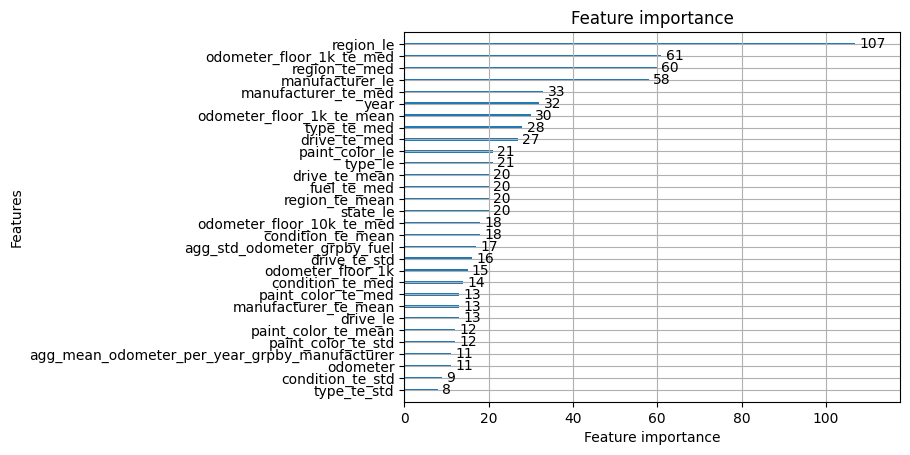

In [30]:
lgb.plot_importance(model, max_num_features=30)